In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import preprocessing
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [6]:
with open('potential_customer.pickle', 'rb') as f:
    potenotal_customer_DB = pickle.load(f)

In [7]:
DB_keys = list(potenotal_customer_DB.keys())
DB_keys

['홍대', '강남', '신사', '천호', '종가', '서울대입구', '노원', '성수']

# LSTM_홍대

In [15]:
hongdae = pd.DataFrame(potenotal_customer_DB[DB_keys[0]])
hongdae

,총생활인구수
시간,
2022060100,32286
2022060101,29091
2022060102,26373
2022060103,24408
2022060104,24206
...,...
2022083101,22160
2022083102,21547
2022083103,21115


In [16]:
hongdae_train = hongdae[:-6*14]
hongdae_test = hongdae[-6*14:]

In [17]:
# parater
scaler = preprocessing.MinMaxScaler()
sequence = 4*7*2
batch_size = 4
epoch = 10
verbose = 1
dropout_ratio = 0.1

In [18]:
## Scaling
train_scaled = scaler.fit_transform(hongdae_train)
test_scaled = scaler.transform(hongdae_test)

In [19]:
## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 56, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 56, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 56, 256)           394240    
                                                                 
 dropout_9 (Dropout)         (None, 56, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 56, 128)           197120    
                                                                 
 dropout_10 (Dropout)        (None, 56, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

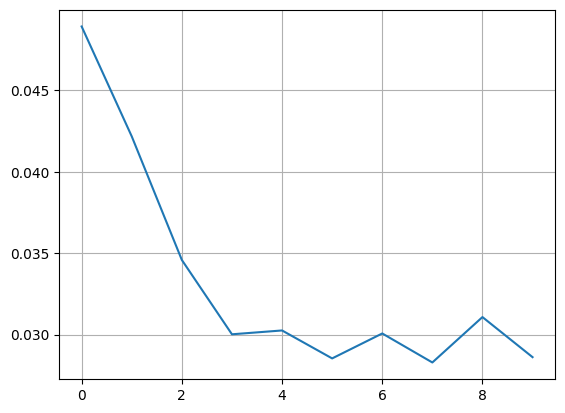

In [20]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 577ms/step - loss: 9.5162e-17


,MAE,MSE,MAPE
Train,2869.269323,1.409969e+07,11.687736
Test,2386.279297,1.091114e+07,8.640052


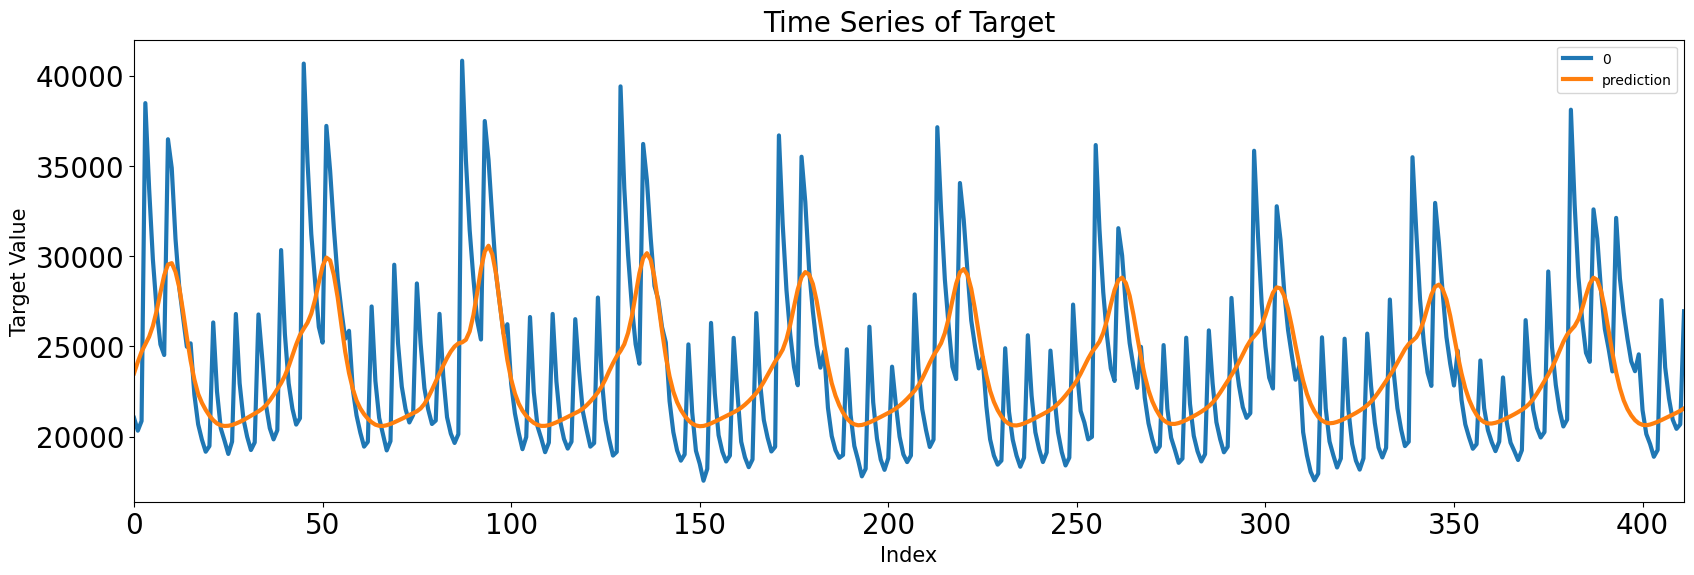

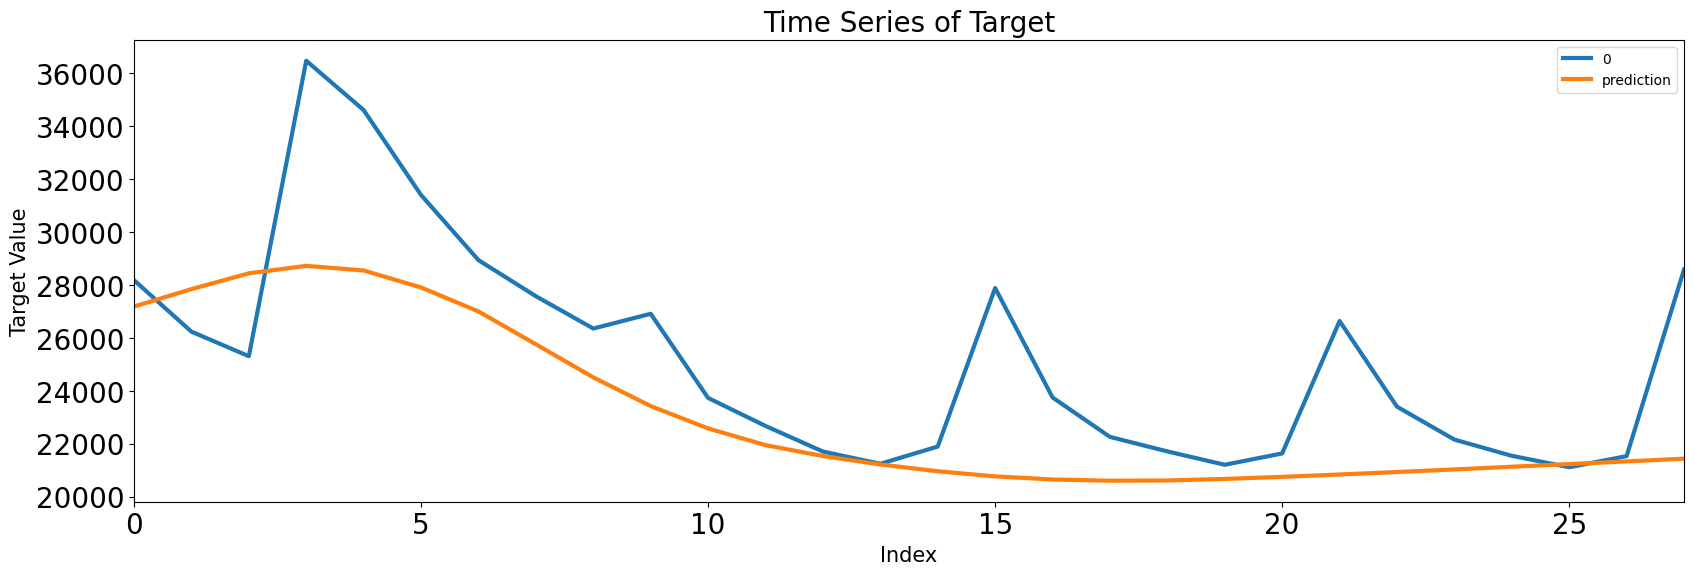

In [21]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# LSTM 모든 지역

In [11]:
# parater
scaler = preprocessing.MinMaxScaler()
sequence = 6*14
batch_size = 6
epoch = 10
verbose = 0
dropout_ratio = 0.1

In [12]:
DB_keys = list(potenotal_customer_DB.keys())
DB_keys

['홍대', '강남', '신사', '천호', '종가', '서울대입구', '노원', '성수']

0it [00:00, ?it/s]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 13s 107ms/step - loss: 0.0499
Epoch 2/10
103/103 [==============================] - 11s 106ms/step - loss: 0.0442
Epoch 3/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0383
Epoch 4/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0342
Epoch 5/10
103/103 [==============================] - 10s 96ms/step - loss: 0.0298
Epoch 6/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0319
Epoch 7/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0284
Epoch 8/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0283
Epoch 9/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0282
Epoch 10/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0276


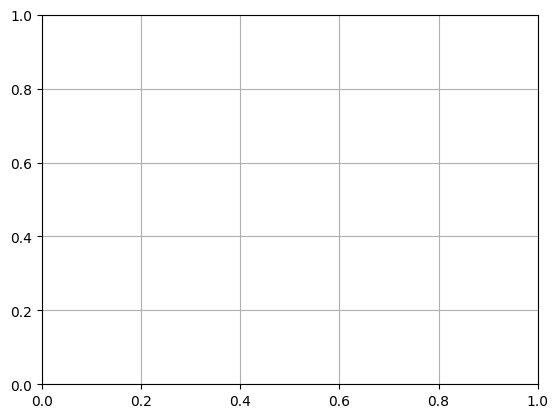

1/1 [==============================] - 0s 403ms/step - loss: 1.1102e-16


,MAE,MSE,MAPE
Train,3059.257343,1.461530e+07,12.820718
Test,2154.772531,9.757048e+06,7.725109


1it [01:45, 105.59s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 12s 96ms/step - loss: 0.0392
Epoch 2/10
103/103 [==============================] - 10s 96ms/step - loss: 0.0342
Epoch 3/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0340
Epoch 4/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0335
Epoch 5/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0347
Epoch 6/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0331
Epoch 7/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0339
Epoch 8/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0351
Epoch 9/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0326
Epoch 10/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0331


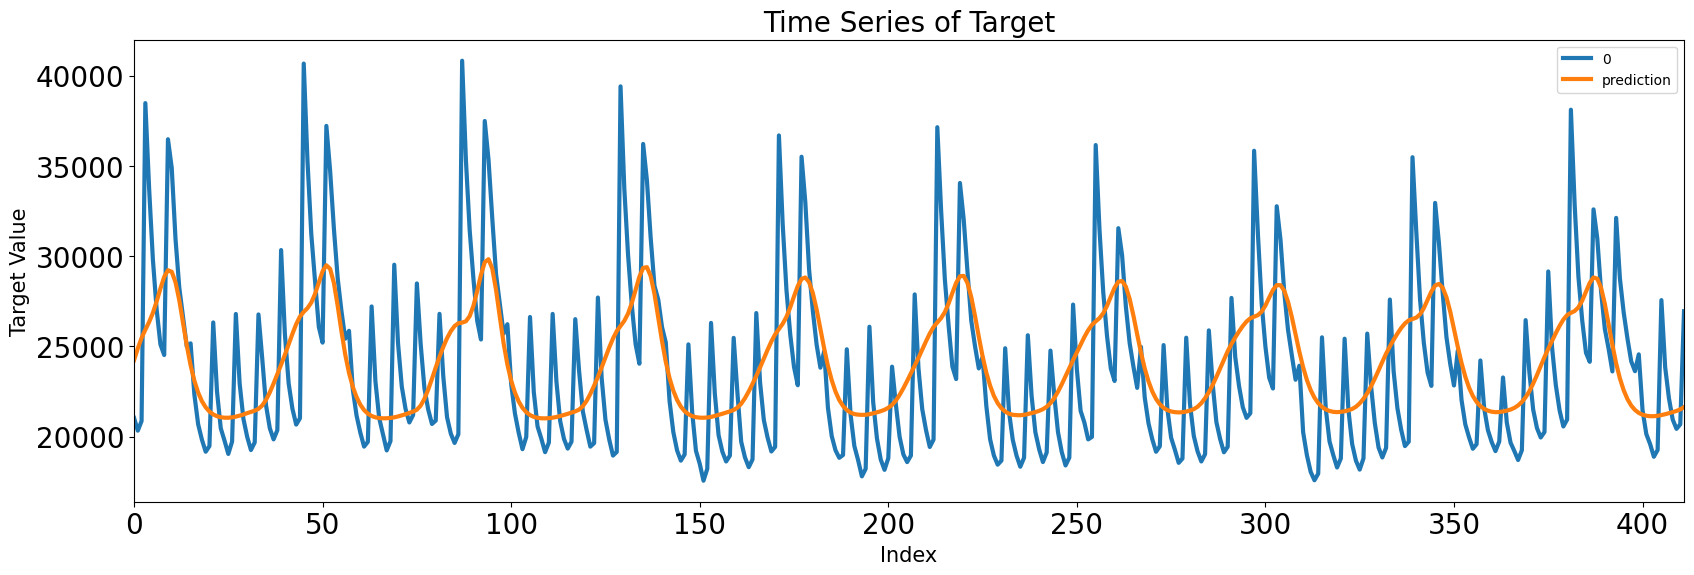

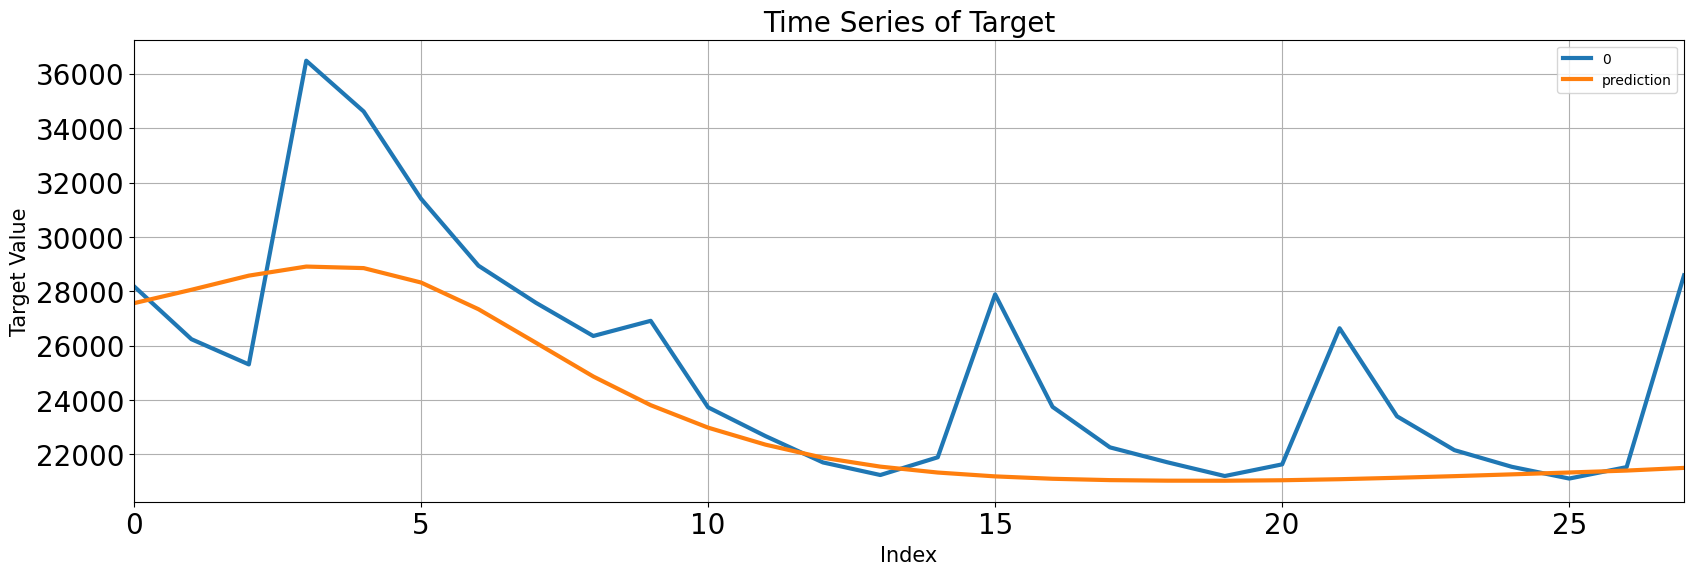

1/1 [==============================] - 0s 404ms/step - loss: 4.1237e-16


,MAE,MSE,MAPE
Train,3727.466560,2.065621e+07,11.789648
Test,2608.545061,1.024328e+07,8.065865


2it [03:30, 104.98s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 12s 96ms/step - loss: 0.0483
Epoch 2/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0399
Epoch 3/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0404
Epoch 4/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0392
Epoch 5/10
103/103 [==============================] - 10s 97ms/step - loss: 0.0409
Epoch 6/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0393
Epoch 7/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0371
Epoch 8/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0356
Epoch 9/10
103/103 [==============================] - 10s 99ms/step - loss: 0.0358
Epoch 10/10
103/103 [==============================] - 10s 99ms/step - loss: 0.0331


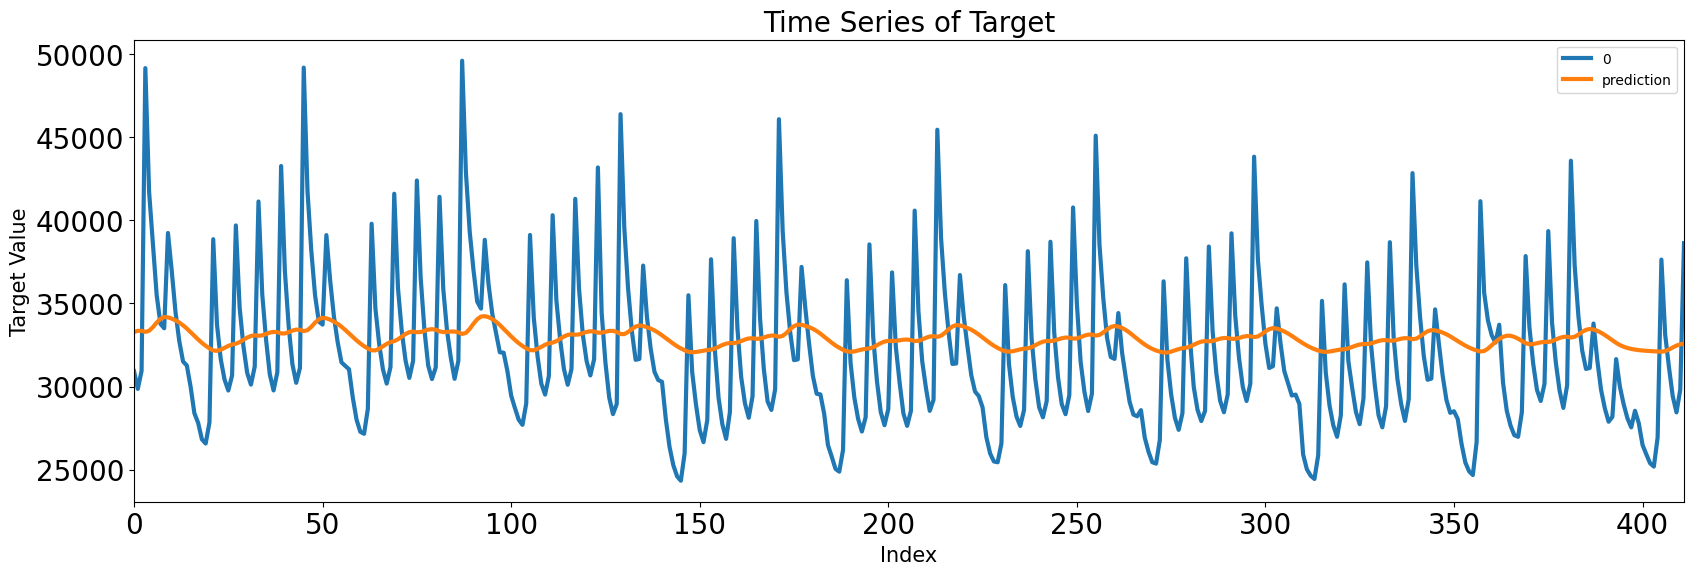

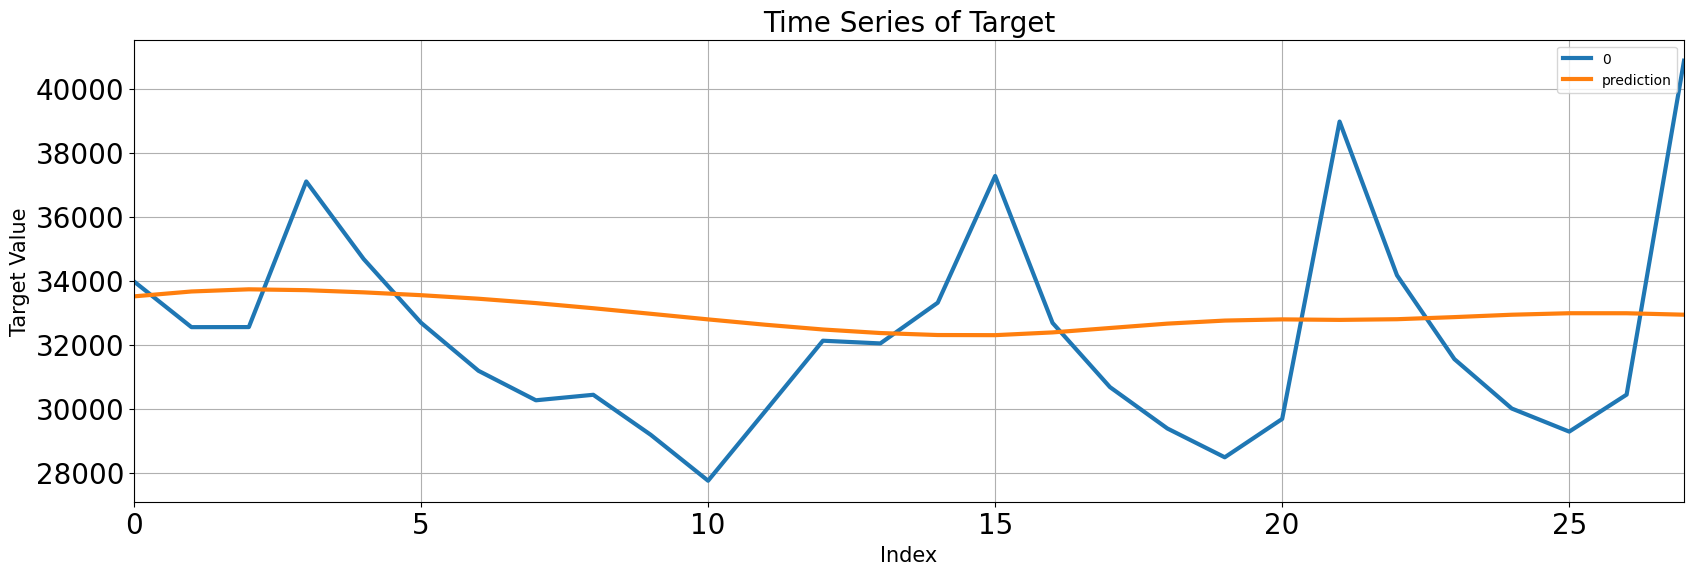

1/1 [==============================] - 0s 394ms/step - loss: 3.9651e-17


,MAE,MSE,MAPE
Train,1910.980805,7.240680e+06,7.135620
Test,1986.781180,6.137089e+06,7.277665


3it [05:14, 104.82s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 12s 98ms/step - loss: 0.0359
Epoch 2/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0306
Epoch 3/10
103/103 [==============================] - 10s 101ms/step - loss: 0.0269
Epoch 4/10
103/103 [==============================] - 10s 102ms/step - loss: 0.0268
Epoch 5/10
103/103 [==============================] - 10s 100ms/step - loss: 0.0267
Epoch 6/10
103/103 [==============================] - 10s 99ms/step - loss: 0.0269
Epoch 7/10
103/103 [==============================] - 10s 99ms/step - loss: 0.0231
Epoch 8/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0238
Epoch 9/10
103/103 [==============================] - 11s 109ms/step - loss: 0.0228
Epoch 10/10
103/103 [==============================] - 10s 99ms/step - loss: 0.0209


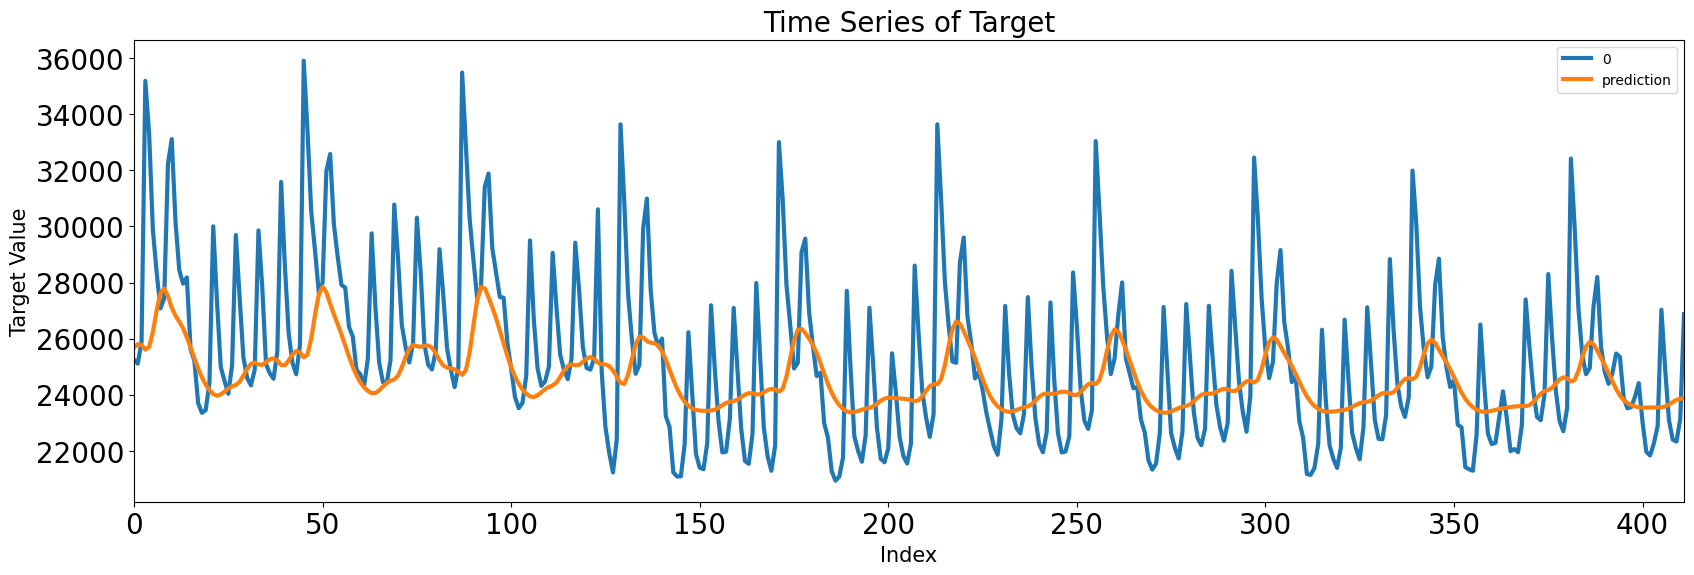

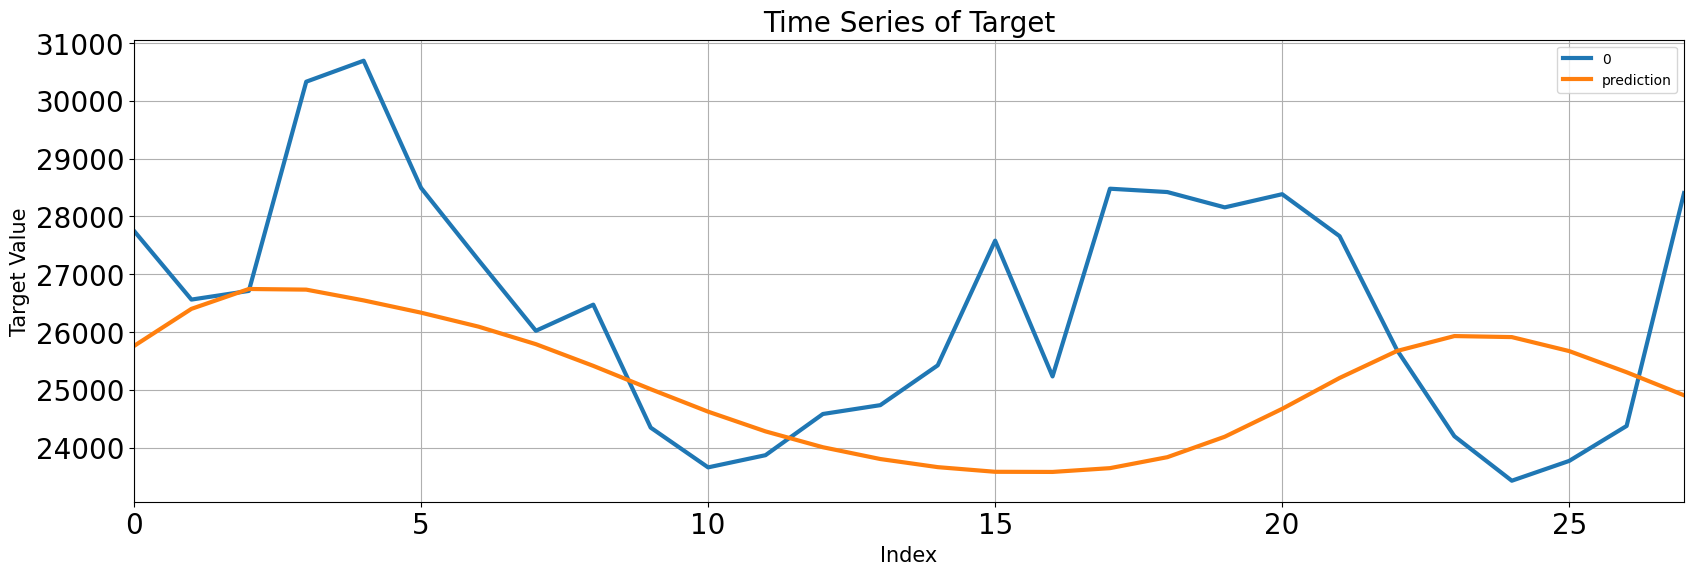

1/1 [==============================] - 0s 428ms/step - loss: 3.4893e-16


,MAE,MSE,MAPE
Train,790.693720,9.890236e+05,2.487921
Test,1931.381069,7.435506e+06,5.587205


4it [07:02, 105.93s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 12s 98ms/step - loss: 0.0438
Epoch 2/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0399
Epoch 3/10
103/103 [==============================] - 10s 100ms/step - loss: 0.0390
Epoch 4/10
103/103 [==============================] - 10s 100ms/step - loss: 0.0391
Epoch 5/10
103/103 [==============================] - 10s 100ms/step - loss: 0.0385
Epoch 6/10
103/103 [==============================] - 11s 111ms/step - loss: 0.0337
Epoch 7/10
103/103 [==============================] - 11s 108ms/step - loss: 0.0301
Epoch 8/10
103/103 [==============================] - 10s 102ms/step - loss: 0.0304
Epoch 9/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0286
Epoch 10/10
103/103 [==============================] - 10s 98ms/step - loss: 0.0277


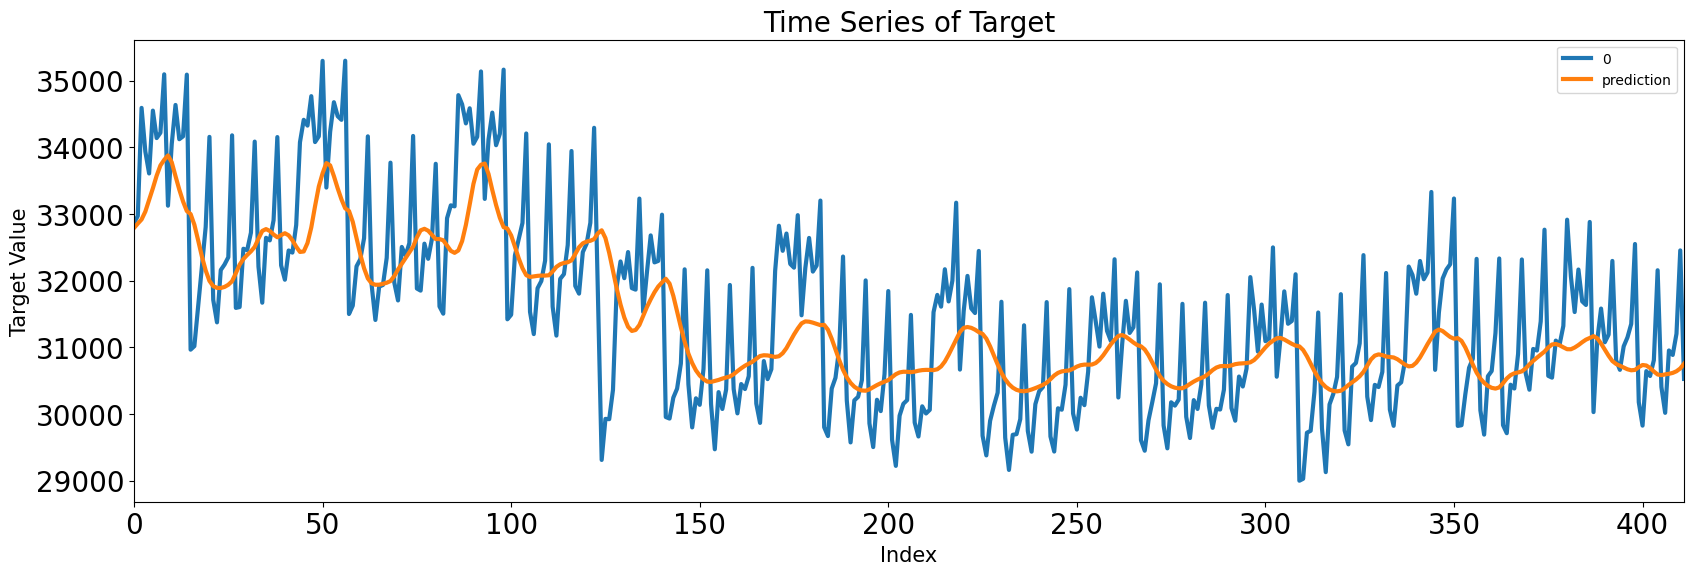

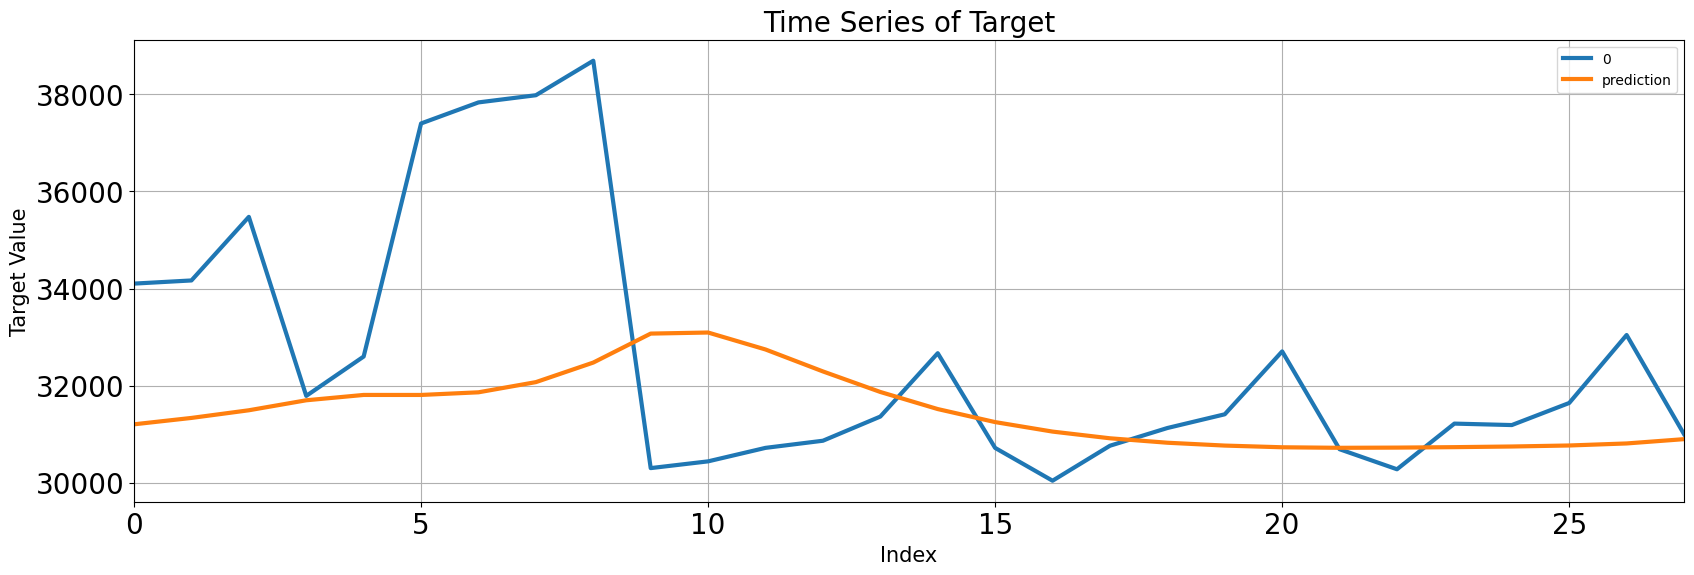

1/1 [==============================] - 0s 398ms/step - loss: 9.9127e-18


,MAE,MSE,MAPE
Train,1508.353692,3.639929e+06,20.477843
Test,1442.951311,3.424393e+06,16.607821


5it [08:50, 106.89s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 12s 100ms/step - loss: 0.0386
Epoch 2/10
103/103 [==============================] - 11s 107ms/step - loss: 0.0320
Epoch 3/10
103/103 [==============================] - 10s 102ms/step - loss: 0.0309
Epoch 4/10
103/103 [==============================] - 11s 104ms/step - loss: 0.0311
Epoch 5/10
103/103 [==============================] - 12s 114ms/step - loss: 0.0277
Epoch 6/10
103/103 [==============================] - 12s 112ms/step - loss: 0.0243
Epoch 7/10
103/103 [==============================] - 12s 112ms/step - loss: 0.0238
Epoch 8/10
103/103 [==============================] - 12s 118ms/step - loss: 0.0225
Epoch 9/10
103/103 [==============================] - 12s 117ms/step - loss: 0.0230
Epoch 10/10
103/103 [==============================] - 12s 115ms/step - loss: 0.0224


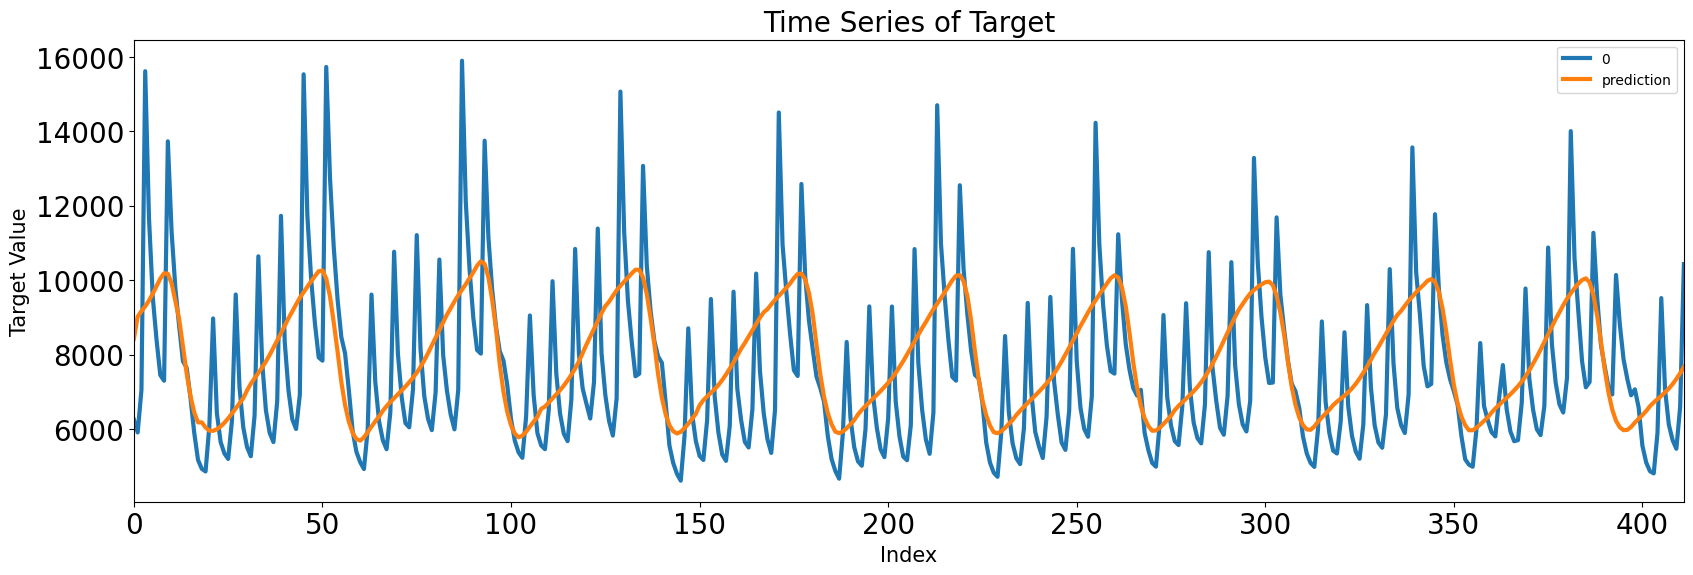

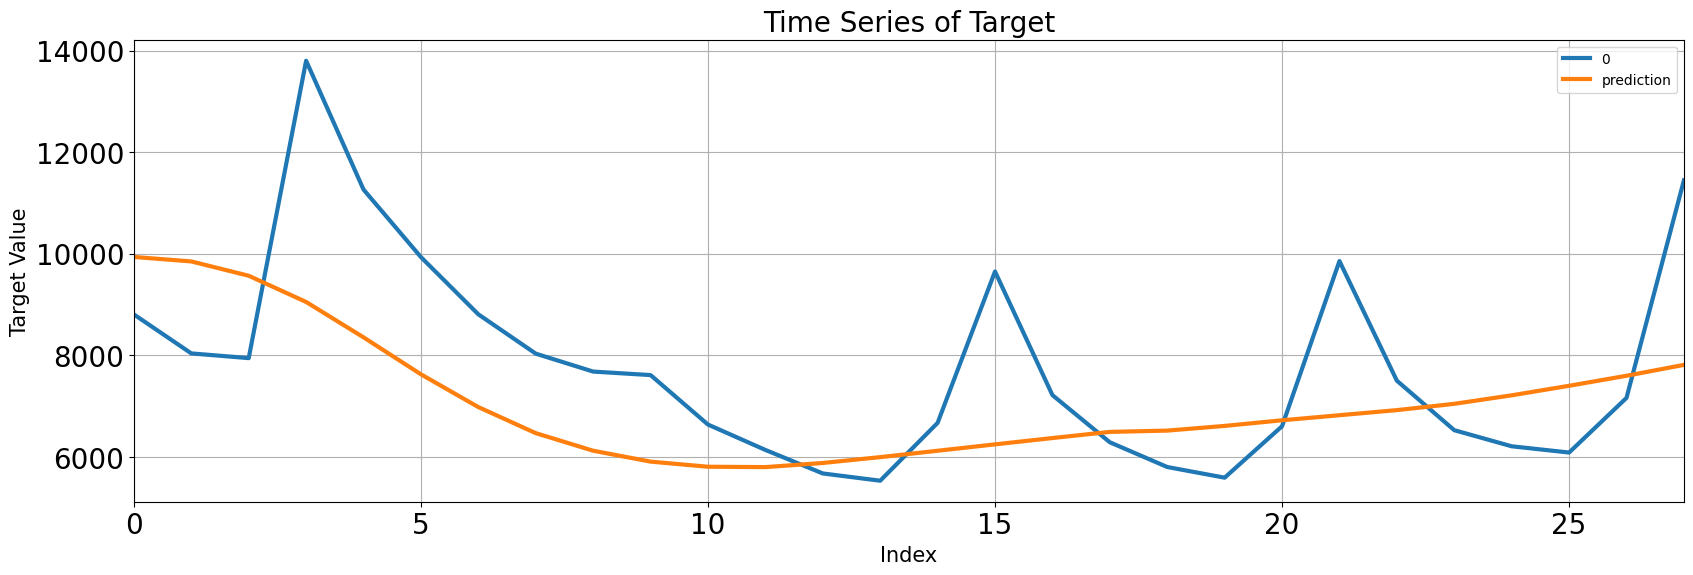

1/1 [==============================] - 0s 414ms/step - loss: 4.1237e-16


,MAE,MSE,MAPE
Train,685.509152,8.254342e+05,4.125747
Test,1390.418283,2.946063e+06,7.491788


6it [10:48, 110.59s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 14s 117ms/step - loss: 0.0486
Epoch 2/10
103/103 [==============================] - 12s 120ms/step - loss: 0.0402
Epoch 3/10
103/103 [==============================] - 13s 127ms/step - loss: 0.0381
Epoch 4/10
103/103 [==============================] - 12s 121ms/step - loss: 0.0326
Epoch 5/10
103/103 [==============================] - 12s 120ms/step - loss: 0.0278
Epoch 6/10
103/103 [==============================] - 13s 121ms/step - loss: 0.0240
Epoch 7/10
103/103 [==============================] - 13s 122ms/step - loss: 0.0233
Epoch 8/10
103/103 [==============================] - 13s 127ms/step - loss: 0.0242
Epoch 9/10
103/103 [==============================] - 13s 125ms/step - loss: 0.0244
Epoch 10/10
103/103 [==============================] - 13s 127ms/step - loss: 0.0211


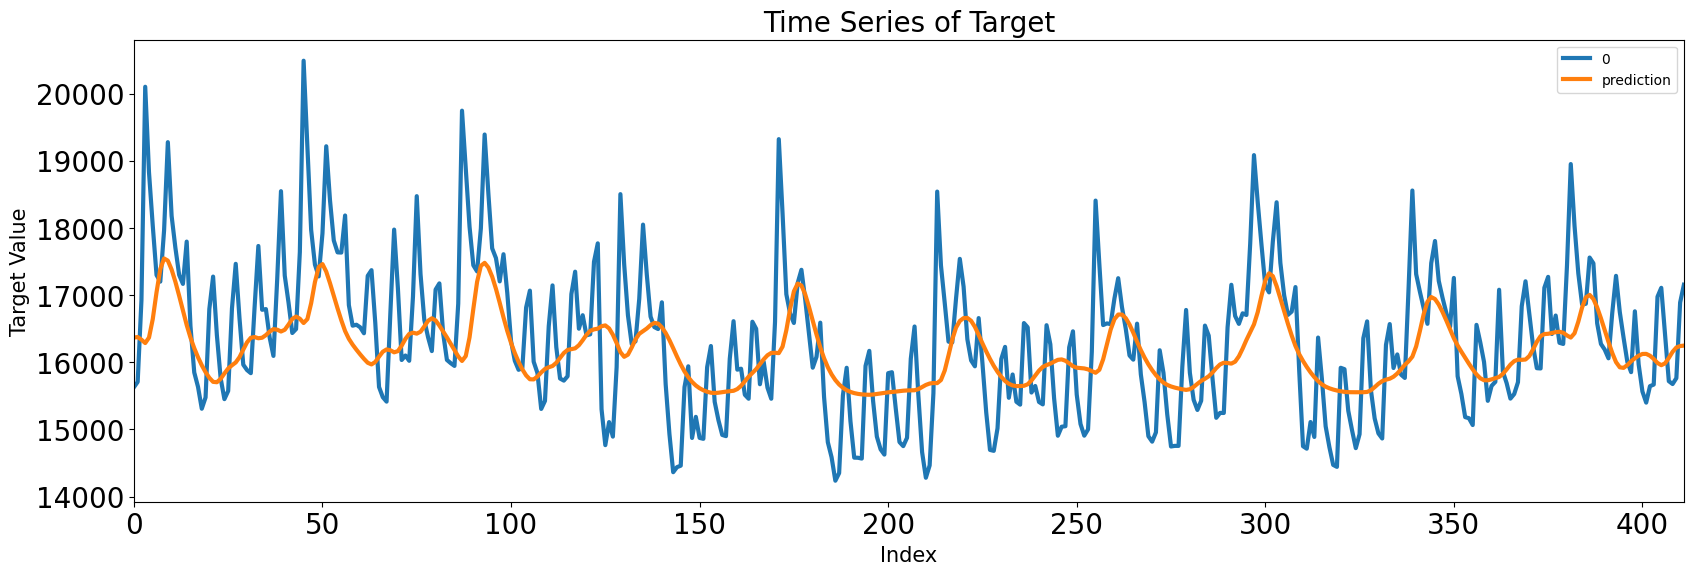

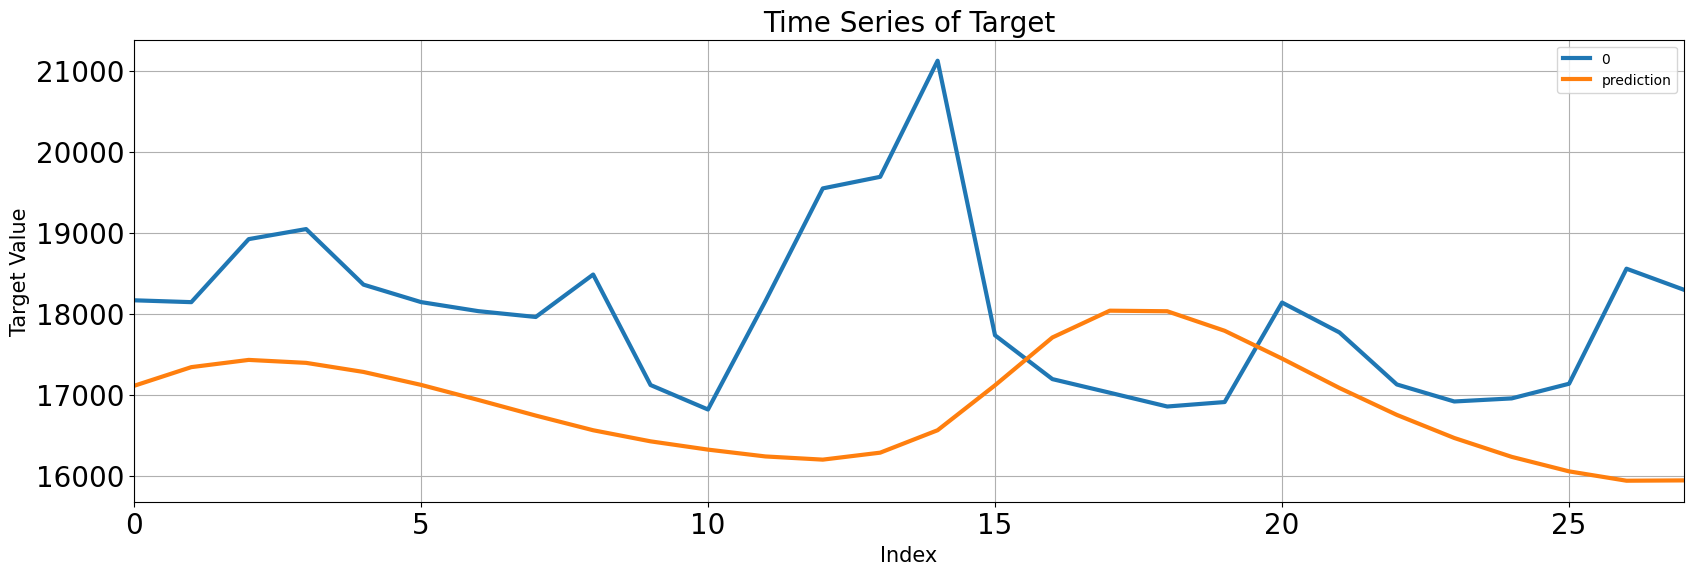

1/1 [==============================] - 0s 440ms/step - loss: 1.9032e-16


,MAE,MSE,MAPE
Train,694.925103,754296.132340,4.327378
Test,630.005685,598659.942407,3.940670


7it [12:59, 117.34s/it]

X_train: (412, 56, 1) Y_train: (412, 1)
X_test: (28, 56, 1) Y_test: (28, 1)
Epoch 1/10
103/103 [==============================] - 15s 127ms/step - loss: 0.0398
Epoch 2/10
103/103 [==============================] - 13s 130ms/step - loss: 0.0350
Epoch 3/10
103/103 [==============================] - 13s 127ms/step - loss: 0.0351
Epoch 4/10
103/103 [==============================] - 15s 141ms/step - loss: 0.0337
Epoch 5/10
103/103 [==============================] - 14s 134ms/step - loss: 0.0330
Epoch 6/10
103/103 [==============================] - 13s 129ms/step - loss: 0.0317
Epoch 7/10
103/103 [==============================] - 14s 132ms/step - loss: 0.0303
Epoch 8/10
103/103 [==============================] - 13s 130ms/step - loss: 0.0297
Epoch 9/10
103/103 [==============================] - 14s 132ms/step - loss: 0.0269
Epoch 10/10
103/103 [==============================] - 14s 141ms/step - loss: 0.0288


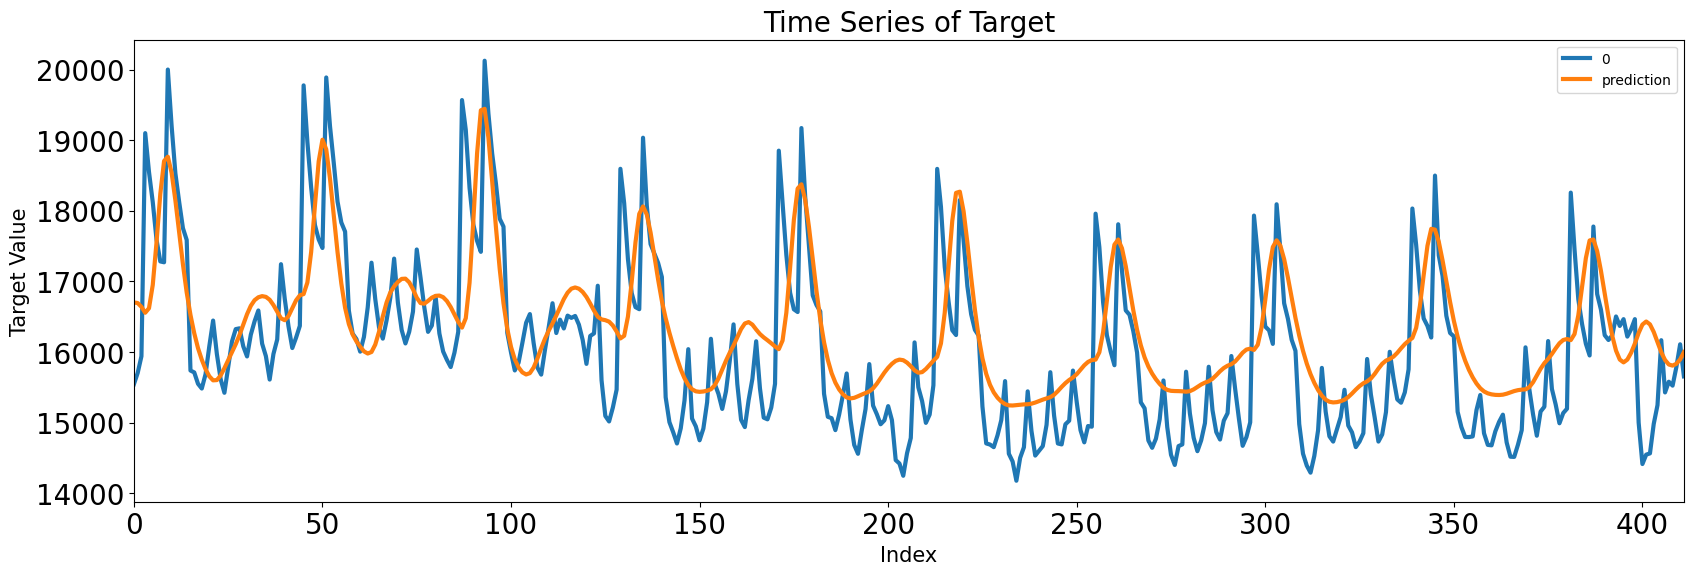

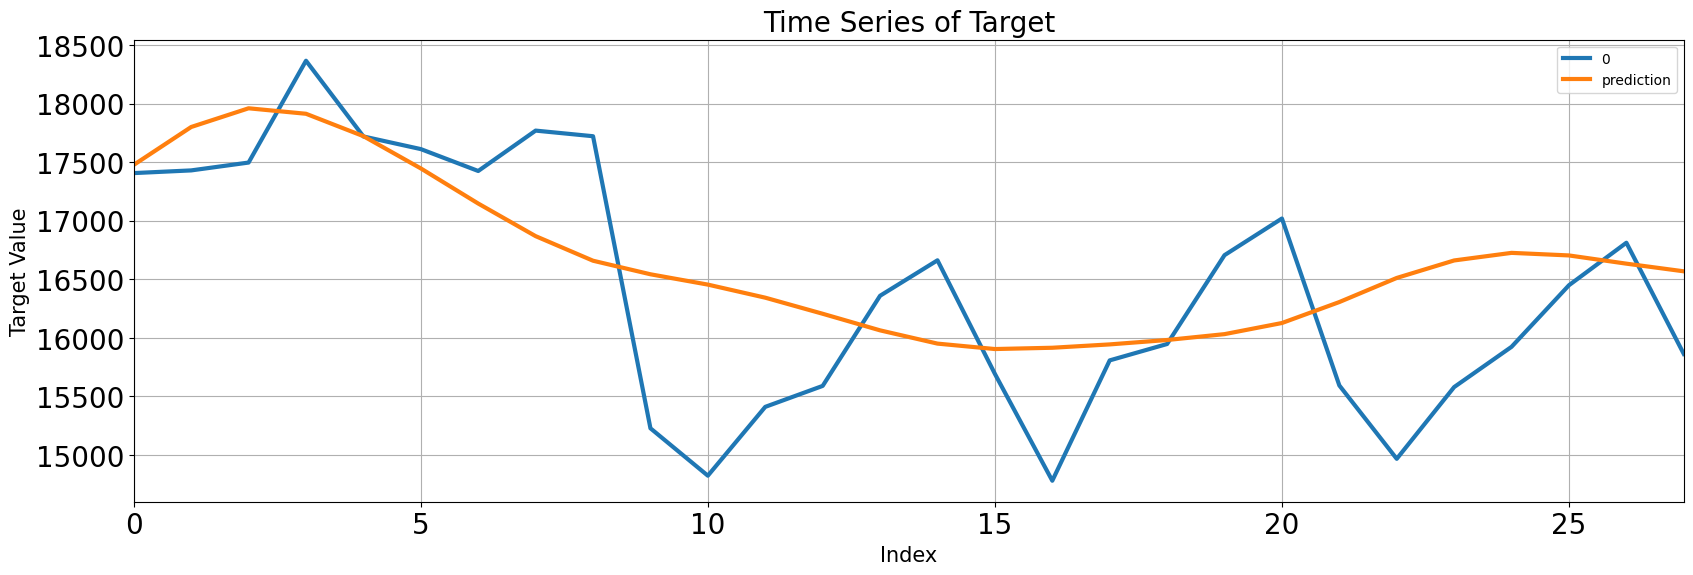

1/1 [==============================] - 0s 448ms/step - loss: 1.9032e-16


,MAE,MSE,MAPE
Train,1549.233697,3.587462e+06,7.750736
Test,1349.355050,2.913828e+06,6.460774


8it [15:20, 115.08s/it]


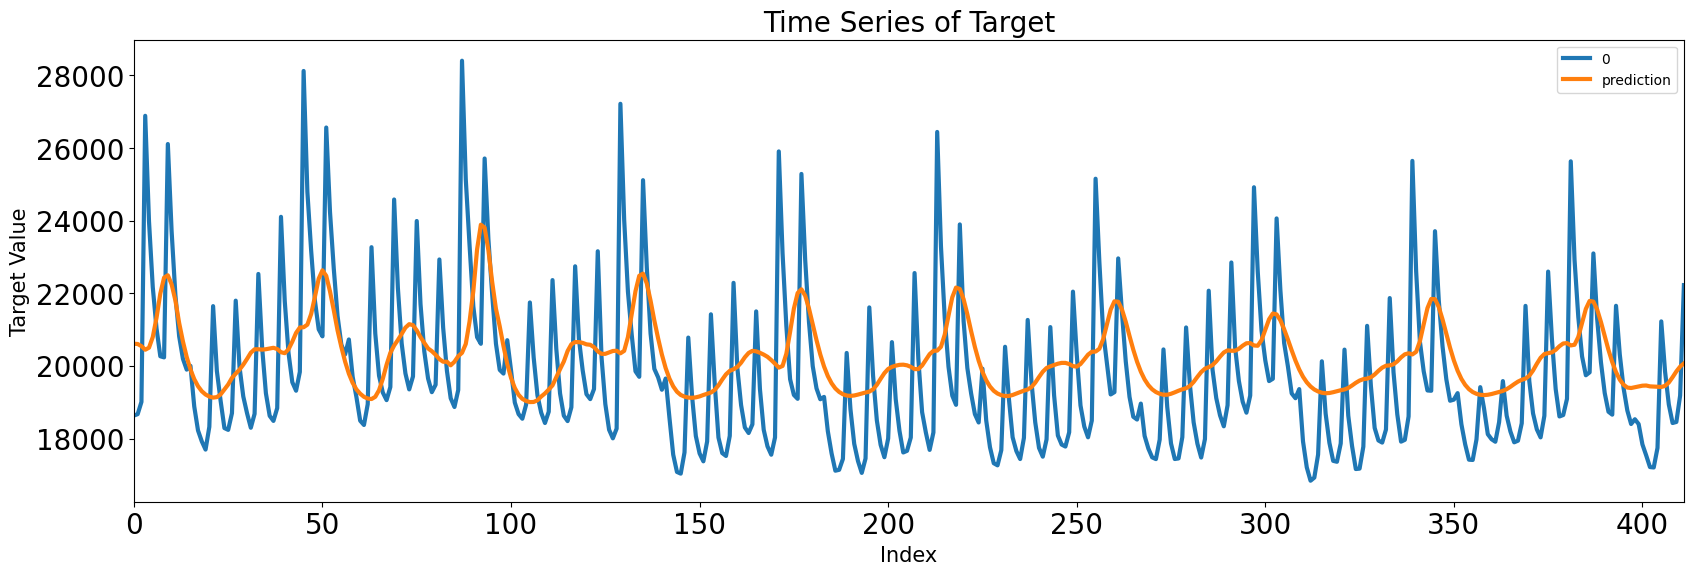

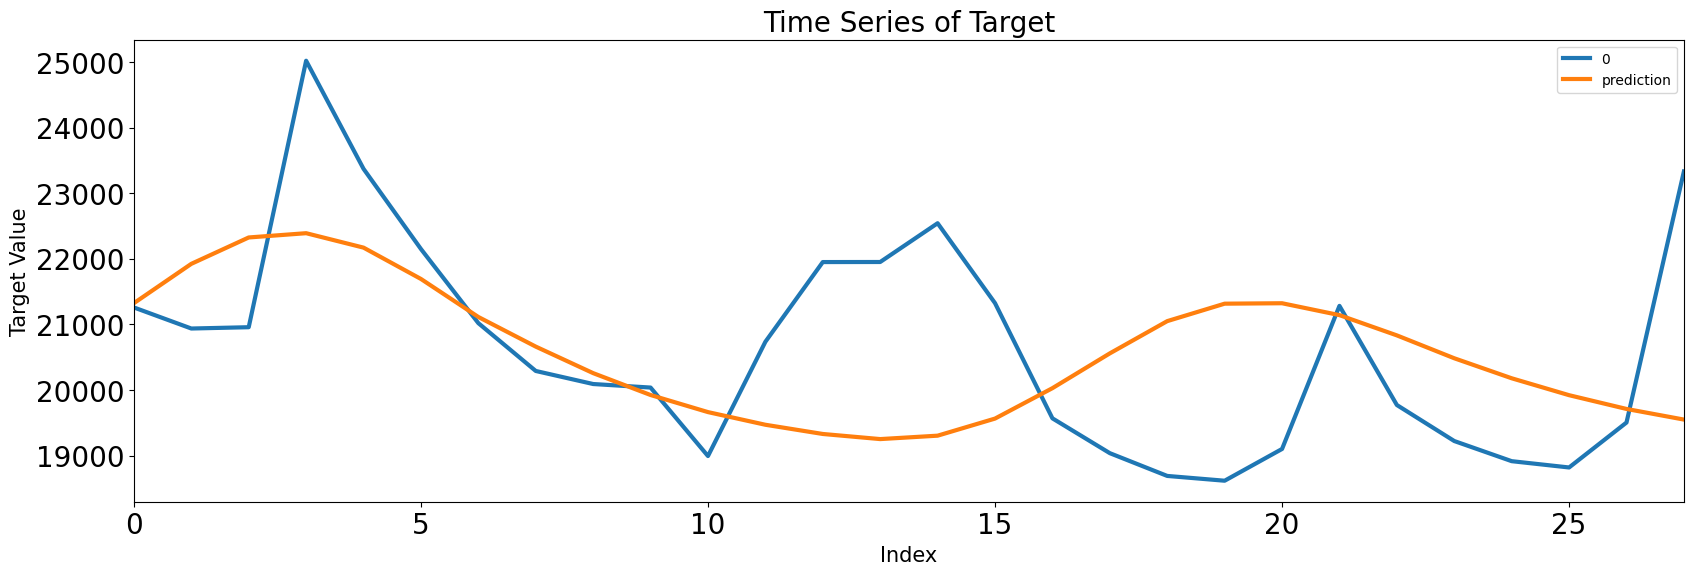

In [24]:
for idx,name in tqdm(enumerate(DB_keys)):
    globals()[name] = pd.DataFrame(potenotal_customer_DB[DB_keys[idx]])
    globals()[f'{name}_train'] = globals()[name][:-6*14]
    globals()[f'{name}_test'] = globals()[name][-6*14:]

    ## Scaling
    train_scaled = scaler.fit_transform(globals()[f'{name}_train'])
    test_scaled = scaler.transform(globals()[f'{name}_test'])

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(train_scaled) - sequence):
        X_train.append(train_scaled[index: index + sequence])
        Y_train.append(train_scaled[index + sequence])
    X_test, Y_test = [], []
    for index in range(len(test_scaled) - sequence):
        X_test.append(test_scaled[index: index + sequence])
        Y_test.append(test_scaled[index + sequence])

    ## Retype and Reshape
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # LSTM
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model_fit = model.fit(X_train, Y_train, 
                        batch_size=batch_size, epochs=epoch,
                        verbose=verbose)
    plt.grid(True)
    plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)


    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler != []:
        Y_train = scaler.inverse_transform(Y_train)
        globals()[f'{name}_train_pred'] = scaler.inverse_transform(Y_train_pred)
        Y_test = scaler.inverse_transform(Y_test)
        globals()[f'{name}_test_pred'] = scaler.inverse_transform(Y_test_pred)
    Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), globals()[f'{name}_train_pred'].flatten(), 
                                                        pd.DataFrame(Y_test), globals()[f'{name}_test_pred'].flatten(), graph_on=True)
    display(Score_LSTM)


In [44]:
for name in DB_keys:
    globals()[f'{name}_pred'] = pd.Series(data=globals()[f'{name}_test_pred'].flatten(), index=globals()[f'{name}_test']['총생활인구수'][:28].index)

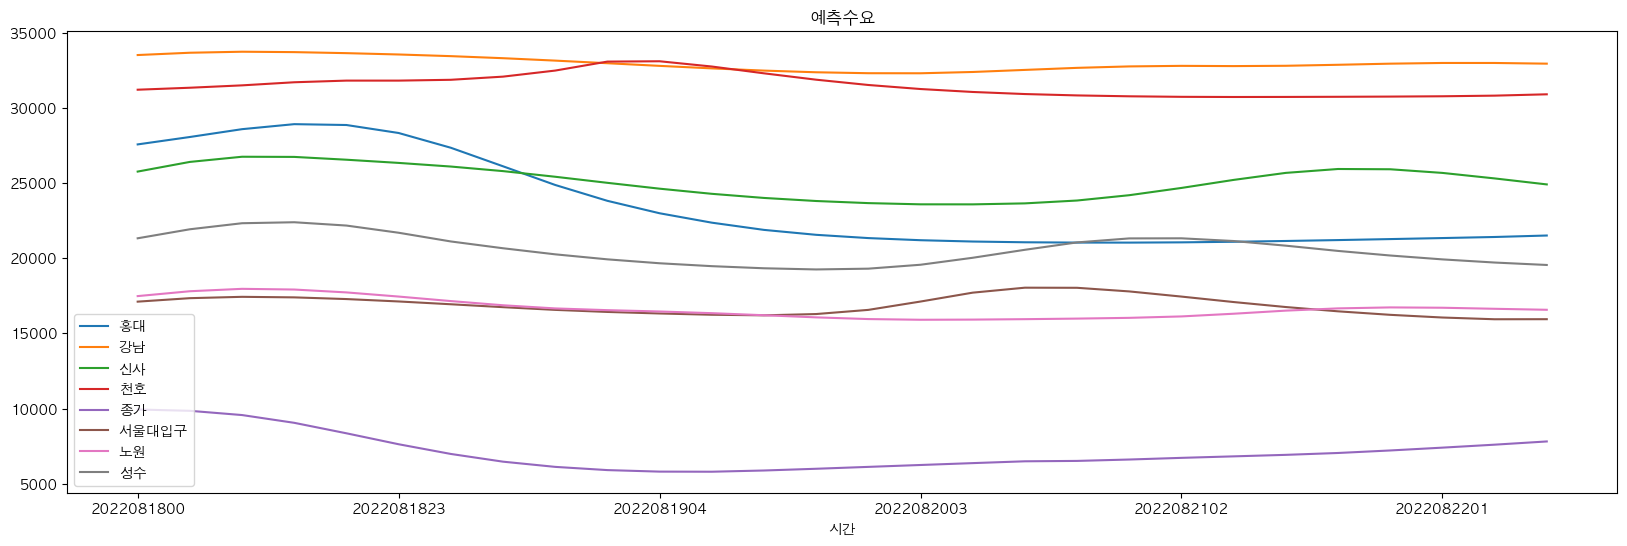

In [48]:
plt.rc('font',family='AppleGothic')
plt.figure(figsize=(20,6))

for name in DB_keys:
    globals()[f'{name}_pred'].plot(label=f'{name}')
plt.legend()
plt.title('예측수요')
plt.show()

# predict

In [71]:
# 오늘 수요 예측
today_predict_potential = pd.DataFrame(index=globals()[f'{name}_pred'][5:11].index)
for name in DB_keys:
    today_predict_potential[f'{name}']=globals()[f'{name}_pred'][5:11].tolist()
today_predict_potential['총합'] = today_predict_potential.sum(axis=1)
today_predict_potential

,홍대,강남,신사,천호,종가,서울대입구,노원,성수,총합
시간,,,,,,,,,
2022081823,28323.695312,33543.828125,26334.521484,31806.373047,7628.183594,17122.203125,17447.988281,21691.343750,183898.136719
2022081900,27342.324219,33433.277344,26092.865234,31860.923828,6983.039551,16935.775391,17147.931641,21112.019531,180908.156738
2022081901,26110.195312,33296.855469,25789.392578,32070.814453,6469.834961,16743.019531,16869.373047,20660.275391,178009.760742
2022081902,24868.019531,33136.218750,25413.886719,32473.902344,6123.565918,16561.882812,16659.421875,20255.886719,175492.784668
2022081903,23813.601562,32962.613281,25010.146484,33070.847656,5909.173340,16425.013672,16543.632812,19922.550781,173657.579590
2022081904,22986.964844,32787.281250,24621.373047,33092.941406,5808.334961,16322.874023,16455.400391,19662.021484,171737.191406


In [92]:
today_need_buss = pd.DataFrame(index=globals()[f'{name}_pred'][5:11].index)
frist_bus = 16
today_need_buss['총합'] = (today_predict_potential['총합']/today_predict_potential['총합'].iloc[0] * frist_bus).round()

for name in DB_keys:
    today_need_buss[f'{name}']=(today_predict_potential[f'{name}']/today_predict_potential['총합'] * today_need_buss['총합']).round()
today_need_buss

,총합,홍대,강남,신사,천호,종가,서울대입구,노원,성수
시간,,,,,,,,,
2022081823,16.0,2.0,3.0,2.0,3.0,1.0,1.0,2.0,2.0
2022081900,16.0,2.0,3.0,2.0,3.0,1.0,1.0,2.0,2.0
2022081901,15.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0
2022081902,15.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0
2022081903,15.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0
2022081904,15.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0
